<img src="https://www.luxonis.com/logo.svg" width="400">

# Training an Image Classification Model

## 🌟 Overview
In this tutorial, we'll go through the process of training a custom image classification model. We'll first create a dataset, set up the training configuration, and then use it to train our own NN model. We'll also validate the performance of our model, export it, and make it ready for deployment on a Luxonis device.

## 📜 Table of Contents
- [🛠️ Installation](#️installation)
- [🗃️ Data Preparation](#data-preparation)
    - [🧐 Parsing the Data](#parsing-the-data)
    - [💾 LuxonisDataset](#luxonisdataset)
- [🏋️‍♂️ Training](#️️training)
    - [⚙️ Configuration](#️configuration)
    - [🦾 Train](#train)
- [✍ Test](#test)
    - [🧠 Infer](#infer)
- [🗂️ Export and Archive](#export-and-archive)
- [🤖 Deploy](#deploy)
- [📷 DepthAI Script](#depthai-script)

<a name="️installation"></a>

## 🛠️ Installation


The main focus of this tutorial is using [`LuxonisTrain`](https://github.com/luxonis/luxonis-train), a user-friendly tool designed to streamline the training of deep learning models, especially for edge devices. We'll also use [`LuxonisML`](https://github.com/luxonis/luxonis-ml) since it provides us with a collection of utility functionality and an easy way of creating and managing computer vision datasets called `LuxonisDataset`. And lastly, we'll use the [`datasets`](https://huggingface.co/docs/datasets/en/index) package to download our data.

In [1]:
%pip install -q opencv-python datasets>=3.1.0 luxonis-train==0.3.0 luxonis-ml==0.6.1 -U


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


<a name ="data-preparation"></a>

## 🗃️ Data Preparation

First, we need to download and prepare our dataset. This tutorial will use a publicly available dataset from HuggingFace called [`Beans`](https://huggingface.co/datasets/AI-Lab-Makerere/beans). Our task is to train a model that can, based on a leaf image, detect the disease type (Angular Leaf Spot and Bean Rust), if any. 

To download the dataset, we'll run this:

In [2]:
from datasets import load_dataset

ds = load_dataset("AI-Lab-Makerere/beans")
example = ds['train'][0]

print(example, example['image'].width, example['image'].height)

{'image_file_path': '/home/albert/.cache/huggingface/datasets/downloads/extracted/967f0d9f61a7a8de58892c6fab6f02317c06faf3e19fba6a07b0885a9a7142c7/train/angular_leaf_spot/angular_leaf_spot_train.0.jpg', 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=500x500 at 0x7DE7F9E0E9D0>, 'labels': 0} 500 500


<a name ="parsing-the-data"></a>

### 🧐 Parsing the Data

Before continuing, it is always good practice to visualize the data and inspect what we have. We'll begin by visualizing an example.

In [3]:
labels = [
  "Angular Leaf Spot",
  "Bean Rust",
  "healthy",
]

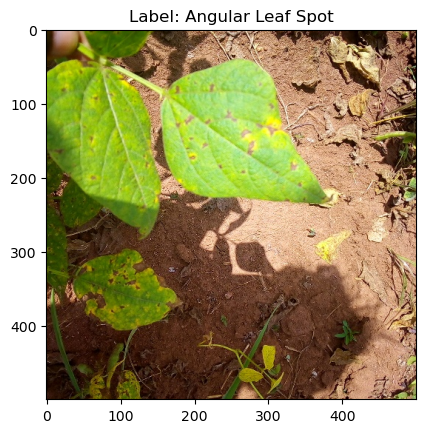

In [4]:
import numpy as np
import matplotlib.pyplot as plt

img = example["image"]
plt.imshow(img)
plt.title(f"Label: {labels[example['labels']]}")
plt.show()

<a name ="luxonisdataset"></a>

### 💾 LuxonisDataset

Now that we know the data, we can create a `LuxonisDataset`. First, we need to create a dataset instance, which we'll call `bean_classification_dataset`.

In [5]:
from luxonis_ml.data import LuxonisDataset

dataset = LuxonisDataset(dataset_name="bean_classification_dataset", delete_existing=True) # if dataset with this name already exists then we delete the old instance

WARNING  /opt/conda/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new    ]8;id=176168;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=707622;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         version of Albumentations is available: 2.0.4 (you have 1.4.22). Upgrade using: pip install               
         -U albumentations. To disable automatic update checks, set the environment variable                       
         NO_ALBUMENTATIONS_UPDATE to 1.                                                                            
           check_for_updates()                                                                                     
                                                                                                                   

INFO     Deleted dataset 'bean_classification_dataset'                                       ]8;id=815497;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=643529;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#766\766]8;;\

To add data to `LuxonisDataset`, you need to create a generator function that yields annotations in the correct format. We need the path to the image and the label for image classification. The authors of the dataset already provide us with the `train`, `validation` and `test`, making our job easier as we don't need to split the data in any way.

Let's now create a function called `process_dir`, which will get a path to the directory and return a generator function of type `DatasetIterator` and a list of paths of added images.

In [6]:
import datasets
from luxonis_ml.data import DatasetIterator
import os


def process_dataset(ds: datasets.dataset_dict.DatasetDict, split: str) -> tuple[DatasetIterator, list[str]]:
    output_dir = os.path.join("bean_hf_dataset", split)
    os.makedirs(output_dir, exist_ok=True)

    images = []
    class_ids = []
    
    for i, sample in enumerate(ds[split], start=1):
        img_path = os.path.join(output_dir, f"img_{i}.jpg")
        sample["image"].save(img_path)
        images.append(img_path)
        class_ids.append(int(sample["labels"]))
    
    def generator() -> DatasetIterator:
        for img, c in zip(images, class_ids):
            yield {
                "file": img,
                "task": "leaf_disease_classification",
                "annotation": {
                    "class": labels[c],
                },
            }
    
    return generator(), images

We can now use this function to process all splits and add them to our `LuxonisDataset` instance. 

In [7]:
train_gen, train_images = process_dataset(ds=ds, split="train")
val_gen, val_images = process_dataset(ds=ds, split="validation")
test_gen, test_images = process_dataset(ds=ds, split="test")

# Add data to the dataset
dataset = dataset.add(train_gen)
dataset = dataset.add(val_gen)
dataset = dataset.add(test_gen)

INFO     Adding data to dataset 'bean_classification_dataset'...                             ]8;id=273206;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=294877;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#866\866]8;;\

INFO     Generating UUIDs...                                                                 ]8;id=306502;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=209749;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#817\817]8;;\

INFO     Checking arrays...                                                                  ]8;id=838158;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=365067;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#778\778]8;;\

Output()

INFO     Saving annotations...                                                               ]8;id=279917;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=525617;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#835\835]8;;\

INFO     Detected new classes for task leaf_disease_classification: ['healthy', 'Angular     ]8;id=769374;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=149404;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#948\948]8;;\
         Leaf Spot', 'Bean Rust']                                                                                  

INFO     Adding data to dataset 'bean_classification_dataset'...                             ]8;id=743576;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=602040;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#866\866]8;;\

INFO     Generating UUIDs...                                                                 ]8;id=820589;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=956734;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#817\817]8;;\

INFO     Checking arrays...                                                                  ]8;id=777281;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=989662;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#778\778]8;;\

INFO     Saving annotations...                                                               ]8;id=548406;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=701445;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#835\835]8;;\

INFO     Adding data to dataset 'bean_classification_dataset'...                             ]8;id=655901;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=447747;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#866\866]8;;\

INFO     Generating UUIDs...                                                                 ]8;id=219005;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=333840;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#817\817]8;;\

INFO     Checking arrays...                                                                  ]8;id=432410;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=976301;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#778\778]8;;\

INFO     Saving annotations...                                                               ]8;id=150079;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py\luxonis_dataset.py]8;;\:]8;id=93384;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/datasets/luxonis_dataset.py#835\835]8;;\

The last step is to specify the `train,` `value`, and `test` subsets. As mentioned, the dataset is already split, so we don't have to do it.

In [8]:
dataset.make_splits(
    splits={
        "train": train_images,
        "val": val_images,
        "test": test_images
    }
)

We can check the dataset's information and visualizations of the annotations to verify that the data is correctly loaded and split into subsets.

In [9]:
!luxonis_ml data info bean_classification_dataset

WARNING  /opt/conda/lib/python3.11/site-packages/albumentations/__ ]8;id=311780;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=621978;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         init__.py:24: UserWarning: A new version of                            
         Albumentations is available: 2.0.4 (you have 1.4.22).                  
         Upgrade using: pip install -U albumentations. To disable               
         automatic update checks, set the environment variable                  
         NO_ALBUMENTATIONS_UPDATE to 1.                                         
           check_for_updates()                                                  
                                                                                
╭───────────────────────────── Dataset Info ──────────────────────────────╮
│ Name: bean_classification_dataset                                       │
│ V

In [61]:
!luxonis_ml data inspect bean_classification_dataset # NOTE: If you are on Google Colab this command will not work

<a name ="️️training"></a>

## 🏋️‍♂️ Training

<a name ="️configuration"></a>

### ⚙️ Configuration

We have prepared the dataset and are almost ready for the actual training. The last step is just to set up our training configuration file. The whole training process in `LuxonisTrain` doesn't require any coding. We advise you to take one of the base configuration files from [here](https://github.com/luxonis/luxonis-train/tree/main/configs) depending on the task and then edit it to fit your needs.

In our case, since we are training an image classification model, we'll take a [`classification_light_model.yaml`](https://github.com/luxonis/luxonis-train/blob/main/configs/classification_light_model.yaml) config as a starting point. There are many parameters that we can change, and we advise you to go through the [`documentation`](https://github.com/luxonis/luxonis-train/blob/main/configs/README.md) to find all of them. In this tutorial, we'll only go through some basic ones to get you started on your journey.

#### Model
In this section, you can either choose one of the predefined architectures (all of them listed [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/config/predefined_models)) or create a completely custom neural network by connecting different nodes, losses, metrics, and visualizers. We'll go with the predefined `ClassificationModel`.

#### Loader
This section of the config refers to the data loading. You can either set up your custom `Loader` or use the default one with the `LuxonisDataset`. In our case, we'll go with the second option; all we need to do is set `dataset_name` to `bean_classification_dataset`.

#### Trainer
In this section, we can set up everything connected to the actual training. You can change preprocessing, batch size, epochs, add callbacks, augmentations, change optimizers, schedulers, and more. Please refer to the [complete documentation](https://github.com/luxonis/luxonis-train/tree/main/configs). 

#### Augmentations
`Luxonis-train` uses [`Albumentations`](https://albumentations.ai/) for augmentations by adding custom ones like `Mosaic4` and `MixUp`. You can use [this demo](https://demo.albumentations.ai/) to experiment and find those that work for your training run. We won't use any augmentations in this training run but feel free to edit it.

#### Callbacks 
Callbacks are very helpful when merging more functionalities into a single training run. For example, we want to train the model, evaluate it on a test subset, export it, and create an archive. These steps can be defined through the config and done by a single call. We won't use them in this tutorial for a more straightforward explanation but feel free to set them up independently. You can check out all the available callbacks [here](https://github.com/luxonis/luxonis-train/tree/main/luxonis_train/callbacks).

Below is a starting point for our config. As mentioned before, we already made some changes to it, so it works with this tutorial (model name and dataset name change), but feel free to edit it further and make it your own. When you are done editing, you can execute the cell, and the file will be written and ready to use.

**Note**: In case you don't have enough computing power on your machine, you can either use [Google Colab](https://colab.research.google.com/) (with GPU enabled), or you can try tweaking the training hyperparameters (such as lowering number of epochs or batch size). However, please be aware that bad parametrization can result in worse performance.

In [10]:
%%writefile bean_classification_model_config.yaml
model:
  name: bean_classification_model
  predefined_model:
    name: ClassificationModel
    params:
      variant: light

loader:
  params:
    dataset_name: bean_classification_dataset

trainer:
  preprocessing:
    train_image_size: [500, 500]
    keep_aspect_ratio: true
    normalize:
      active: true

  batch_size: 16
  epochs: &epochs 20
  n_workers: 8
  validation_interval: 10
  n_log_images: 8

  optimizer:
    name: Adam
    params:
      lr: 0.0003

  scheduler:
    name: ConstantLR

Overwriting bean_classification_model_config.yaml


<a name ="train"></a>

### 🦾 Train

To start the training, we need to initialize the `LuxonisModel`, pass it the path to the configuration file, and call the `train()` method on it.

**Note**: LuxonisTrain also supports all these commands through usage of its CLI ([docs here](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#-cli)), no code required. We won't use them for tutorial purposes, but feel free to use them when you do it yourself.

In [11]:
from luxonis_train import LuxonisModel

config_path = "bean_classification_model_config.yaml"

luxonis_model = LuxonisModel(config_path)
luxonis_model.train()

INFO     Using predefined model: `ClassificationModel`                                                ]8;id=152672;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/config/config.py\config.py]8;;\:]8;id=255096;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/config/config.py#135\135]8;;\

INFO     Main metric: `F1Score`                                                                       ]8;id=367398;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/config/config.py\config.py]8;;\:]8;id=700030;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/config/config.py#162\162]8;;\

INFO     Predefined model detected. Applying predefined model configuration rules.                    ]8;id=201444;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/config/config.py\config.py]8;;\:]8;id=174915;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/config/config.py#666\666]8;;\

INFO     Setting accumulate_grad_batches to %d (trainer.batch_size=%d)                                ]8;id=986636;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/config/config.py\config.py]8;;\:]8;id=572151;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/config/config.py#671\671]8;;\

INFO     GPU available: True (cuda), used: True                                                     ]8;id=457371;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=979668;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\

INFO     TPU available: False, using: 0 TPU cores                                                   ]8;id=429733;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=737424;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\

INFO     HPU available: False, using: 0 HPUs                                                        ]8;id=194004;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=16026;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\

WARNING  Classification task detected. Classification tasks can be properly augmented  ]8;id=439899;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/augmentations/albumentations_engine.py\albumentations_engine.py]8;;\:]8;id=725547;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/augmentations/albumentations_engine.py#270\270]8;;\
         only for multi-label tasks, where each class is tied to a bounding box. In                                
         such cases, the classes belonging to bboxes falling outside the image are                                 
         removed. In other cases, the annotation is kept as is.                                                    

WARNING  Classification task detected. Classification tasks can be properly augmented  ]8;id=402490;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/augmentations/albumentations_engine.py\albumentations_engine.py]8;;\:]8;id=502118;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/augmentations/albumentations_engine.py#270\270]8;;\
         only for multi-label tasks, where each class is tied to a bounding box. In                                
         such cases, the classes belonging to bboxes falling outside the image are                                 
         removed. In other cases, the annotation is kept as is.                                                    

WARNING  Classification task detected. Classification tasks can be properly augmented  ]8;id=769515;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/augmentations/albumentations_engine.py\albumentations_engine.py]8;;\:]8;id=850722;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/data/augmentations/albumentations_engine.py#270\270]8;;\
         only for multi-label tasks, where each class is tied to a bounding box. In                                
         such cases, the classes belonging to bboxes falling outside the image are                                 
         removed. In other cases, the annotation is kept as is.                                                    

INFO     Train loader - splits: ['train'], size: 1034                                                   ]8;id=203585;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=724670;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#141\141]8;;\

INFO     Val loader - splits: ['val'], size: 133                                                        ]8;id=961411;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=172058;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#141\141]8;;\

INFO     Test loader - splits: ['test'], size: 128                                                      ]8;id=722051;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=278767;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#141\141]8;;\

WARNING  /opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning:     ]8;id=252480;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=562012;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         This DataLoader will create 8 worker processes in total. Our suggested max number of worker               
         in current system is 4, which is smaller than what this DataLoader is going to create.                    
         Please be aware that excessive worker creation might get DataLoader running slow or even                  
         freeze, lower the worker number to avoid potential slowness/freeze if necessary.                          
           warnings.warn(                                                                                          
                                                                                                                   

INFO     Checkpoints will be saved in: output/3-amethyst-snake                                          ]8;id=803472;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=536828;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#265\265]8;;\

INFO     Starting training...                                                                           ]8;id=59885;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=474091;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#272\272]8;;\

INFO     The following callbacks returned in `LightningModule.configure_callbacks` will override    ]8;id=549609;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=893857;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\
         existing callbacks passed to Trainer: ModelCheckpoint, RichModelSummary                                   

INFO     You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, ]8;id=15605;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=747204;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\
         you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will                         
         trade-off precision for performance. For more details, read                                               
         https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.se                
         t_float32_matmul_precision                                                                                

2025-02-26 11:12:13.214163: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-26 11:12:13.258840: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-26 11:12:13.258889: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-26 11:12:13.260520: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-26 11:12:13.269189: I tensorflow/core/platform/cpu_feature_guar

┏━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┳━━━━━━━┓
┃   ┃ Name                            ┃ Type               ┃ Params ┃ Mode  ┃
┡━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━╇━━━━━━━┩
│ 0 │ nodes                           │ ModuleDict         │ 11.7 M │ train │
│ 1 │ nodes.-ResNet                   │ ResNet             │ 11.7 M │ train │
│ 2 │ nodes.-ClassificationHead       │ ClassificationHead │  1.5 K │ train │
│ 3 │ losses                          │ ModuleDict         │  1.5 K │ train │
│ 4 │ losses.-ClassificationHead      │ ModuleDict         │  1.5 K │ train │
│ 5 │ metrics                         │ ModuleDict         │  1.5 K │ train │
│ 6 │ metrics.-ClassificationHead     │ ModuleDict         │  1.5 K │ train │
│ 7 │ visualizers                     │ ModuleDict         │  1.5 K │ train │
│ 8 │ visualizers.-ClassificationHead │ ModuleDict         │  1.5 K │ train │
└───┴─────────────────────────────────┴────────────────────┴────────┴───────┘

Trainable params: 11.7 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 11.7 M                                                                                               
Total estimated model params size (MB): 46                                                                         
Modules in train mode: 93                                                                                          
Modules in eval mode: 0

Output()

WARNING  /opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning:     ]8;id=403602;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=384251;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         This DataLoader will create 8 worker processes in total. Our suggested max number of worker               
         in current system is 4, which is smaller than what this DataLoader is going to create.                    
         Please be aware that excessive worker creation might get DataLoader running slow or even                  
         freeze, lower the worker number to avoid potential slowness/freeze if necessary.                          
           warnings.warn(                                                                                          
                                                                                                                   

INFO     Computing metrics on val subset ...                                               ]8;id=305536;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=284714;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#860\860]8;;\

INFO     Metrics computed.                                                                 ]8;id=770888;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=16432;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#862\862]8;;\

INFO     Validation loss: 1.5654                                                          ]8;id=414776;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=824044;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1104\1104]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 1.5654154419898987

Metrics:

 -ClassificationHead  
┏━━━━━━━━━━┳━━━━━━━━━┓
┃ Name     ┃ Value   ┃
┡━━━━━━━━━━╇━━━━━━━━━┩
│ F1Score  │ 0.00000 │
│ Accuracy │ 0.00000 │
│ Recall   │ 0.00000 │
└──────────┴─────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (-ClassificationHead/F1Score): 0.0000                     ]8;id=464524;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=986180;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1115\1115]8;;\

WARNING  /opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning:     ]8;id=403602;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=384251;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         This DataLoader will create 8 worker processes in total. Our suggested max number of worker               
         in current system is 4, which is smaller than what this DataLoader is going to create.                    
         Please be aware that excessive worker creation might get DataLoader running slow or even                  
         freeze, lower the worker number to avoid potential slowness/freeze if necessary.                          
           warnings.warn(                                                                                          
                                                                                                                   

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=319044;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=671269;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#860\860]8;;\

INFO     Metrics computed.                                                                 ]8;id=870427;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=81023;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#862\862]8;;\

INFO     Validation loss: 0.0148                                                          ]8;id=105761;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=44444;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1104\1104]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 0.014810292292774344

Metrics:

 -ClassificationHead  
┏━━━━━━━━━━┳━━━━━━━━━┓
┃ Name     ┃ Value   ┃
┡━━━━━━━━━━╇━━━━━━━━━┩
│ F1Score  │ 1.00000 │
│ Accuracy │ 1.00000 │
│ Recall   │ 1.00000 │
└──────────┴─────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (-ClassificationHead/F1Score): 1.0000                     ]8;id=748230;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=563442;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1115\1115]8;;\

Output()

WARNING  /opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning:     ]8;id=986180;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=183641;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         This DataLoader will create 8 worker processes in total. Our suggested max number of worker               
         in current system is 4, which is smaller than what this DataLoader is going to create.                    
         Please be aware that excessive worker creation might get DataLoader running slow or even                  
         freeze, lower the worker number to avoid potential slowness/freeze if necessary.                          
           warnings.warn(                                                                                          
                                                                                                                   

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

INFO     Computing metrics on val subset ...                                               ]8;id=344864;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=837512;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#860\860]8;;\

INFO     Metrics computed.                                                                 ]8;id=778407;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=530992;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#862\862]8;;\

INFO     Validation loss: 0.1047                                                          ]8;id=695686;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=447600;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1104\1104]8;;\

─────────────────────────────────────────────────── Validation ────────────────────────────────────────────────────

Loss: 0.10472182122369607

Metrics:

 -ClassificationHead  
┏━━━━━━━━━━┳━━━━━━━━━┓
┃ Name     ┃ Value   ┃
┡━━━━━━━━━━╇━━━━━━━━━┩
│ F1Score  │ 0.96992 │
│ Accuracy │ 0.96992 │
│ Recall   │ 0.96992 │
└──────────┴─────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Validation main metric (-ClassificationHead/F1Score): 0.9699                     ]8;id=54653;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=371556;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1115\1115]8;;\

INFO     `Trainer.fit` stopped: `max_epochs=20` reached.                                            ]8;id=686885;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=309118;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\

INFO     Training finished                                                                              ]8;id=853522;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=983394;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#279\279]8;;\

INFO     Checkpoints saved in: output/3-amethyst-snake                                                  ]8;id=851413;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=637524;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#280\280]8;;\

`LuxonisTrain` has also already implemented automatic tracking of training runs. By default, `Tensorboard` is used, and to look at the losses, metrics, and visualizations during training, we can inspect the logs. If you check the `output` folder, you'll see that every run creates a new directory, and each run also has its training logs in the `./output/tensorboard_logs` where the name of the folder matches the run's name. To make all the subsequent commands work automatically, please set the name of your run below.

In [12]:
# RUN_NAME = "<YOUR_RUN_NAME>"
RUN_NAME = "output/3-amethyst-snake"

In [13]:
%load_ext tensorboard
%tensorboard --logdir output/tensorboard_logs/{RUN_NAME}/ # TODO: Change the name of the training run

<a name ="test"></a>

## ✍ Test

Now, we have a trained model that performs well on the validation set. The next step is to check its performance on the testing set, a collection of images we've kept hidden from the model. It should only be used to evaluate whether the model is good objectively. Since this is an image classification task, we use the Accuracy, Recall, and F1 Score metrics to check the model performance quantitatively.

If you check out the run directory, you'll see two folders inside: `best_val_metric` and `min_val_loss`. Both have checkpoint files generated during training based on best validation metric performance and minimal validation loss. For evaluation, we'll want to use one of these checkpoints; we recommend that you use one that has the lowest validation loss.

In [14]:
weights = luxonis_model.get_min_loss_checkpoint_path() # gets checkpoint where validation loss was the lowest
# weights = luxonis_model.get_best_metric_checkpoint_path() # gets checkpoint where validation metric was the highest

metrics = luxonis_model.test(view="test", weights=weights)

WARNING  /opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py:1022: You  ]8;id=538605;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=254686;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         are using `torch.load` with `weights_only=False` (the current default value), which uses the              
         default pickle module implicitly. It is possible to construct malicious pickle data which                 
         will execute arbitrary code during unpickling (See                                                        
         https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details).              
         In a future release, the default value for `weights_only` will be flipped to `True`. This                 
         limits the functions that could be executed during unpickling. Arbitrary objects will no                  
         longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the                
         user via `torch.serialization.add_safe_globals`. We recommend you start setting                           
         `weights_only=True` for any use case where you don't have full control of the loaded file.                
         Please open an issue on GitHub for any issues related to this experimental feature.                       
                                                                                                                   

INFO     Loaded checkpoint from                                                           ]8;id=553704;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=694482;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1049\1049]8;;\
         /home/jovyan/update-tutorials/output/3-amethyst-snake/min_val_loss/bean_classifi                          
         cation_model_loss=0.0148_09.ckpt.                                                                         

INFO     The following callbacks returned in `LightningModule.configure_callbacks` will override    ]8;id=238460;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=453013;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\
         existing callbacks passed to Trainer: ModelCheckpoint, RichModelSummary                                   

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


WARNING  /opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning:     ]8;id=60115;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=823620;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         This DataLoader will create 8 worker processes in total. Our suggested max number of worker               
         in current system is 4, which is smaller than what this DataLoader is going to create.                    
         Please be aware that excessive worker creation might get DataLoader running slow or even                  
         freeze, lower the worker number to avoid potential slowness/freeze if necessary.                          
           warnings.warn(                                                                                          
                                                                                                                   

Output()

INFO     Computing metrics on test subset ...                                              ]8;id=956228;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=999522;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#860\860]8;;\

INFO     Metrics computed.                                                                 ]8;id=15250;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=849848;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#862\862]8;;\

INFO     Test loss: 0.1049                                                                ]8;id=29545;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=446712;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1104\1104]8;;\

────────────────────────────────────────────────────── Test ───────────────────────────────────────────────────────

Loss: 0.10493560244503897

Metrics:

 -ClassificationHead  
┏━━━━━━━━━━┳━━━━━━━━━┓
┃ Name     ┃ Value   ┃
┡━━━━━━━━━━╇━━━━━━━━━┩
│ F1Score  │ 0.95312 │
│ Accuracy │ 0.95312 │
│ Recall   │ 0.95312 │
└──────────┴─────────┘

───────────────────────────────────────────────────────────────────────────────────────────────────────────────────

INFO     Test main metric (-ClassificationHead/F1Score): 0.9531                           ]8;id=171672;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=548646;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1115\1115]8;;\

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                  Test metric                   ┃                  DataLoader 0                  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│                   test/loss                    │              0.10493560135364532               │
│ test/loss/-ClassificationHead/CrossEntropyLoss │              0.10493560135364532               │
│    test/metric/-ClassificationHead/Accuracy    │                    0.953125                    │
│    test/metric/-ClassificationHead/F1Score     │                    0.953125                    │
│     test/metric/-ClassificationHead/Recall     │                    0.953125                    │
└────────────────────────────────────────────────┴────────────────────────────────────────────────┘

<a name ="infer"></a>

### 🧠 Infer

Usually, we also want to visualize the prediction of the trained model on test images to ensure it does what it is supposed to do. This is called inference, and we can perform it either on one of the views (e.g., test) or a random image, directory of images, or whole video (for more details, refer to the [docs](https://github.com/luxonis/luxonis-train/tree/main?tab=readme-ov-file#inference)). In our case, we'll infer the model on test images.

In [15]:
# NOTE: If you are using Google Colab use this and images will be saved to "infer_results_beans_model" directory
luxonis_model.infer(weights=weights, save_dir="infer_results_beans_model", view="test")

# NOTE: If you are not using Google Colab use this and images will be displayed
# luxonis_model.infer(
#     weights=weights,
#     view="test"
# ) 

WARNING  /opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py:1022: You  ]8;id=194930;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=569841;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         are using `torch.load` with `weights_only=False` (the current default value), which uses the              
         default pickle module implicitly. It is possible to construct malicious pickle data which                 
         will execute arbitrary code during unpickling (See                                                        
         https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details).              
         In a future release, the default value for `weights_only` will be flipped to `True`. This                 
         limits the functions that could be executed during unpickling. Arbitrary objects will no                  
         longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the                
         user via `torch.serialization.add_safe_globals`. We recommend you start setting                           
         `weights_only=True` for any use case where you don't have full control of the loaded file.                
         Please open an issue on GitHub for any issues related to this experimental feature.                       
                                                                                                                   

INFO     Loaded checkpoint from                                                           ]8;id=162405;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=377411;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1049\1049]8;;\
         /home/jovyan/update-tutorials/output/3-amethyst-snake/min_val_loss/bean_classifi                          
         cation_model_loss=0.0148_09.ckpt.                                                                         

INFO     The following callbacks returned in `LightningModule.configure_callbacks` will override    ]8;id=904072;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py\rank_zero.py]8;;\:]8;id=316788;file:///opt/conda/lib/python3.11/site-packages/lightning_utilities/core/rank_zero.py#64\64]8;;\
         existing callbacks passed to Trainer: ModelCheckpoint, RichModelSummary                                   

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


WARNING  /opt/conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:617: UserWarning:     ]8;id=331665;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=487405;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         This DataLoader will create 8 worker processes in total. Our suggested max number of worker               
         in current system is 4, which is smaller than what this DataLoader is going to create.                    
         Please be aware that excessive worker creation might get DataLoader running slow or even                  
         freeze, lower the worker number to avoid potential slowness/freeze if necessary.                          
           warnings.warn(                                                                                          
                                                                                                                   

Output()

Now, let's visualize one of the predictions.

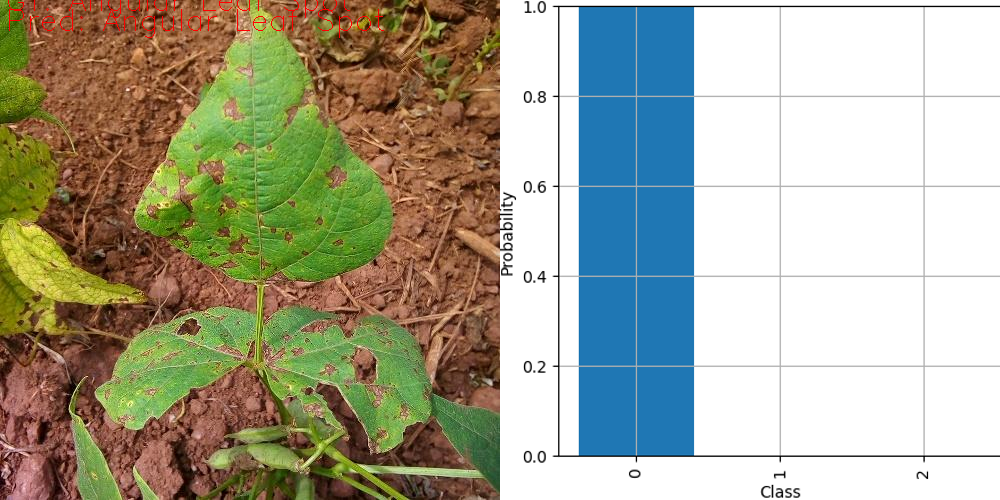

In [16]:
from IPython.display import Image
Image(filename='infer_results_beans_model/-ClassificationHead_ClassificationVisualizer_0.png')

<a name ="export-and-archive"></a>

## 🗂️ Export and Archive

Once the model is trained and tested, we want to prepare it for deployment on the device. This preparation consists of 2 steps. First, we want to export the model trained with PyTorch to a more general format called [`Open Neural Network Exchange (ONNX)`](https://onnx.ai/). Then, we want to package this exported model with all the metadata containing information about the inputs, outputs, and training configuration used. This is called archiving. These steps can be done quickly with just one command in `LuxonisTrain`.

In [17]:
archieve_path = luxonis_model.archive(weights=weights)
print("Model archieved to:", archieve_path)

WARNING  /opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py:1022: You  ]8;id=118115;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py\logging.py]8;;\:]8;id=562661;file:///opt/conda/lib/python3.11/site-packages/luxonis_ml/utils/logging.py#86\86]8;;\
         are using `torch.load` with `weights_only=False` (the current default value), which uses the              
         default pickle module implicitly. It is possible to construct malicious pickle data which                 
         will execute arbitrary code during unpickling (See                                                        
         https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details).              
         In a future release, the default value for `weights_only` will be flipped to `True`. This                 
         limits the functions that could be executed during unpickling. Arbitrary objects will no                  
         longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the                
         user via `torch.serialization.add_safe_globals`. We recommend you start setting                           
         `weights_only=True` for any use case where you don't have full control of the loaded file.                
         Please open an issue on GitHub for any issues related to this experimental feature.                       
                                                                                                                   

INFO     Loaded checkpoint from                                                           ]8;id=229494;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=855528;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#1049\1049]8;;\
         /home/jovyan/update-tutorials/output/3-amethyst-snake/min_val_loss/bean_classifi                          
         cation_model_loss=0.0148_09.ckpt.                                                                         

WARNING  No model executable specified for archiving.                                                   ]8;id=43359;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=383411;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#721\721]8;;\

INFO     Exporting model to ONNX...                                                                     ]8;id=592096;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=505673;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#723\723]8;;\

INFO     Model exported to output/3-amethyst-snake/export/bean_classification_model.onnx   ]8;id=944772;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py\luxonis_lightning.py]8;;\:]8;id=59422;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/models/luxonis_lightning.py#681\681]8;;\

INFO     Simplifying ONNX model...                                                               ]8;id=446680;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py\export_utils.py]8;;\:]8;id=154307;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py#41\41]8;;\

INFO     ONNX model saved to output/3-amethyst-snake/export/bean_classification_model.onnx       ]8;id=782666;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py\export_utils.py]8;;\:]8;id=685123;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/utils/export_utils.py#47\47]8;;\

INFO     NN Archive saved to output/3-amethyst-snake/archive/bean_classification_model.onnx.tar.xz      ]8;id=246;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=41369;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#787\787]8;;\

Model archieved to: output/3-amethyst-snake/archive/bean_classification_model.onnx.tar.xz


INFO     SIGTERM received, stopping training...                                                         ]8;id=420045;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py\core.py]8;;\:]8;id=879833;file:///opt/conda/lib/python3.11/site-packages/luxonis_train/core/core.py#251\251]8;;\

Notice that two new folders were created in our run directory. One is called `export` and has an ONNX model while the other is called `archive` which has `.tar.xz` file. The tar file is a compressed file that holds the aforementioned ONNX model with all the model metadata.

<a name ="deploy"></a>

## 🤖 Deploy

Now that we have successfully exported and archived the model, we aim to deploy it to the Luxonis device. The model's specific format depends on the Luxonis device series you have. We will show you how to use our [`ModelConverter`](https://github.com/luxonis/modelconverter) to convert the model as simply as possible. 

We'll start by installing the `ModelConverter`.

In [ ]:
%pip install -q modelconv@git+https://github.com/luxonis/modelconverter.git@main -U

We will use `ModelConverter`'s Python API, which utilizes our [`HubAI`](https://hub.luxonis.com) to convert the model in the background. To start with the conversion, you need to create an account on the `HubAI` platform and obtain the API key for your team.

To log in to HubAI, use the following command:

In [ ]:
!modelconverter hub login

To convert the model, we can use either CLI or Python API. We'll use the latter. For more information, please look [here](https://github.com/luxonis/modelconverter?tab=readme-ov-file#online-usage).

The call below will create a new model card inside your team on `HubAI` with the model file and details uploaded. It will further convert the model on the cloud to the selected target platform (e.g. [`RVC2`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc2/), [`RVC4`](https://rvc4.docs.luxonis.com/hardware/platform/rvc/rvc4/)) and download the converted model to your device. Choosing the target is as simple as setting a `target` argument in the `convert` function.

Besides this, there are some platform-specific parameters. To check them out, please visit our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/offline/modelconverter/#ModelConverter-Parameters-Platform-Specific).

In [ ]:
NN_ARCHIVE_PATH = "<YOUR_MODEL_ARCHIVE_PATH>"

In [2]:
from modelconverter import convert


converted_model = convert(
    "rvc2", 
    path=NN_ARCHIVE_PATH,
    name="Bean Classifier",
    description_short="Bean Classification Model",
    tasks=["CLASSIFICATION"],
    license_type="MIT",
    is_public=False
)

Model 'Bean Classifier' created with ID '5a8cc4d0-c603-4712-aa68-b96348f8cd53'

Model variant 'Bean Classifier 500x500' created with ID 'e5bdbd2a-ff79-4b73-9dce-3d8915283066'

Model instance 'Bean Classifier 500x500 base instance' created with ID '74bf3e43-75fd-4524-9d90-c812e5555273'

File 'bean_classification_model.onnx.tar.xz' uploaded to model instance '74bf3e43-75fd-4524-9d90-c812e5555273'

Model instance 'Bean Classifier 500x500 exported to rvc2' created for rvc2 export with ID 
'82609464-17da-4da2-b50f-9fb99b79e0d0'

/Users/jancuhel/miniconda3/envs/luxonis-tutorials/lib/python3.11/site-packages/rich/live.py:231: UserWarning: 
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Donwloaded 'bean-classifier-500x500-exported-to-rvc2/bean_classification_model.rvc2.tar.xz'

We have successfully converted our trained model for an RVC2 device, so let's test it! Please copy the path to the downloaded archive with the converted model from the output log of the last code cell; we will use it in the next section.

In [1]:
MODEL_PATH = "bean-classifier-500x500-exported-to-rvc2/bean_classification_model.rvc2.tar.xz"

To check out other possible ways to convert your model for our devices, please refer to our [documentation](https://rvc4.docs.luxonis.com/software/ai-inference/conversion/rvc-conversion/).

<a name ="depthai-script"></a>

## 📷 DepthAI Script

To test our model on one of our cameras, we first need to install [`DepthAI`](https://rvc4.docs.luxonis.com/software/) in version 3 and [`DepthAI Nodes`](https://rvc4.docs.luxonis.com/software/ai-inference/depthai-nodes/). Moreover, the script we'll write must run locally and require a Luxonis device connected to your machine.

In [ ]:
%pip install --extra-index-url https://artifacts.luxonis.com/artifactory/luxonis-python-release-local/ depthai==3.0.0a13
%pip install -q depthai-nodes@git+https://github.com/luxonis/depthai-nodes.git@main -U

Here is the script to run the model on the DepthAI device:

In [ ]:
import cv2
from depthai_nodes import ParsingNeuralNetwork
from depthai_nodes.ml.messages import Classifications
import numpy as np
import depthai as dai


def visualize_classification(frame: np.ndarray, message: Classifications) -> bool:
    """Visualizes the classification on the frame."""
    classes = message.classes[:2]
    scores = message.scores[:2]
    if frame.shape[0] < 128:
        frame = cv2.resize(frame, (frame.shape[1] * 2, frame.shape[0] * 2))
    for i, (cls, score) in enumerate(zip(classes, scores)):
        cv2.putText(
            frame,
            f"{cls}: {score:.2f}",
            (10, 20 + 20 * i),
            cv2.FONT_HERSHEY_TRIPLEX,
            0.5,
            255,
        )

    cv2.imshow("Classification", frame)
    if cv2.waitKey(1) == ord("q"):
        cv2.destroyAllWindows()
        return True

    return False


with dai.Pipeline() as pipeline:
    cam = pipeline.create(dai.node.Camera).build()
    nn_archive = dai.NNArchive(MODEL_PATH)
    # Create the neural network node
    nn_with_parser = pipeline.create(ParsingNeuralNetwork).build(
        cam.requestOutput((500, 500), type=dai.ImgFrame.Type.BGR888p, fps=30), 
        nn_archive
    )
    # Create output queues
    parser_output_queue = nn_with_parser.out.createOutputQueue()
    frame_queue = nn_with_parser.passthrough.createOutputQueue()

    # Start pipeline
    pipeline.start()

    while pipeline.isRunning():
        # Get the frame
        frame: dai.ImgFrame = frame_queue.get().getCvFrame()
        # Get the parsed message containing the segmentation mask
        parser_msg: dai.ImgFrame = parser_output_queue.get()
        if visualize_classification(frame, parser_msg):
            pipeline.stop()
            break

Yay! 🎉🎉🎉 Huge congratulations, you have successfully finished this tutorial in which you deployed a bean leaf classification model trained using `luxonis-train` on a dataset to our camera!